## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score

%matplotlib inline

В этом примере мы попробуем предсказать итоговую оценку участинка только на основе **его действий**

In [2]:
df_train = pd.read_csv("train.csv")
df_user = pd.read_csv("user_decision.csv")

## Рассмотрим датасет по ближе

In [3]:
df_train.shape


(680, 5)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   680 non-null    int64  
 1   Analytical thinking  680 non-null    float64
 2   Systemic thinking    680 non-null    float64
 3   Adaptability         680 non-null    float64
 4   Focus                680 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 26.7 KB


In [5]:
df_train.head(30)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0
5,10908,4.0,4.0,5.0,5.0
6,10378,4.0,5.0,5.0,4.0
7,10220,5.0,4.0,5.0,5.0
8,10612,5.0,4.0,4.0,5.0
9,10776,4.0,4.0,5.0,5.0


In [6]:
df_user.shape

(60228, 3)

In [7]:
df_user.head(3)

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420


In [8]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60228 entries, 0 to 60227
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      60228 non-null  int64
 1   period       60228 non-null  int64
 2   decision_id  60228 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


Заметим что в есть категория где пользватель совершал больше действий

In [9]:
df_user.period.value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение периода')

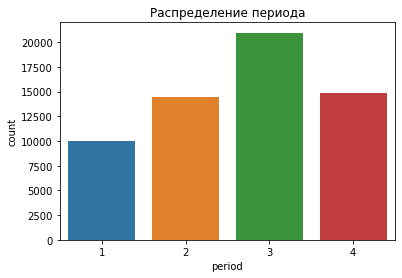

In [10]:
sns.countplot(x = "period" , data  = df_user).set_title('Распределение периода')

Text(0.5, 1.0, 'Распределение действий')

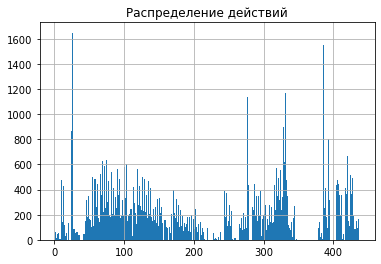

In [11]:
df_user["decision_id"].hist(bins = 300).set_title('Распределение действий')

sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = df_user, x= "decision_id", y = "period").set_title('Зависимость действий от игровго периода')

### Добавим новых значений

Узнаем частоту команд участника в каждом периоде

In [12]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in df_train.id.values)]

In [13]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [14]:
df_decision_count.head(5)

decision_id
user_id period             
10001   1                29
        2                23
        3                39
        4                15
10003   1                21

In [15]:
for id in df_train.id.values:
  for period in range(1,5):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [16]:
df_train.head(3)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0


In [17]:

df_train['Adaptability'].value_counts()

5.0    318
4.0    308
3.0     36
6.0     15
1.0      2
2.0      1
Name: Adaptability, dtype: int64

In [18]:
Xnorm = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1).fillna(0, inplace=True)
ynorm = df_train['Analytical thinking'].fillna(0, inplace=True)

In [19]:
df_train['Adaptability'].value_counts()

5.0    318
4.0    308
3.0     36
6.0     15
1.0      2
2.0      1
Name: Adaptability, dtype: int64

In [20]:
df_train=df_train.fillna(df_train.mean())
df_train['sum']=df_train['period_1']+df_train['period_2']+df_train['period_3']+df_train['period_4']
df_train['quad']=df_train['period_1'] * df_train['period_1'] + df_train['period_2'] * df_train['period_2'] + df_train['period_3'] * df_train['period_3'] + df_train['period_4'] * df_train['period_4']
df_train['medan']=(df_train['period_1']+df_train['period_2']+df_train['period_3']+df_train['period_4'])/4
df_train['sqr_median']=np.sqrt(df_train['medan'])
df_train['sqr_sum']=np.sqrt(df_train['sum'])




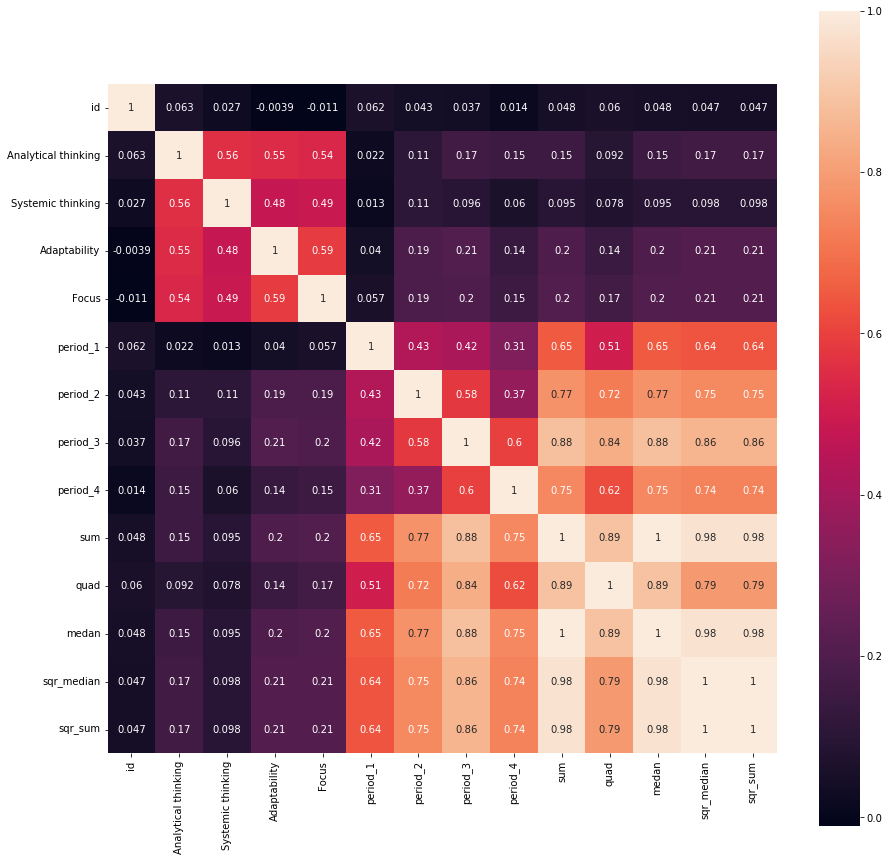

In [21]:
plt.rcParams['figure.figsize']=(15,15)

g = sns.heatmap(df_train.corr(), square = True, annot=True)

In [22]:
df_train

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,sum,quad,medan,sqr_median,sqr_sum
0,10884,4.0,4.0,4.0,4.0,7.000000,14.000000,28.0,10.0,59.000000,1129.000000,14.750000,3.840573,7.681146
1,10106,5.0,4.0,5.0,5.0,21.000000,21.000000,12.0,8.0,62.000000,1090.000000,15.500000,3.937004,7.874008
2,10438,6.0,5.0,5.0,5.0,62.000000,45.000000,63.0,38.0,208.000000,11282.000000,52.000000,7.211103,14.422205
3,10130,5.0,4.0,5.0,5.0,26.000000,28.000000,34.0,66.0,154.000000,6972.000000,38.500000,6.204837,12.409674
4,10667,4.0,5.0,5.0,5.0,58.000000,70.000000,194.0,35.0,357.000000,47125.000000,89.250000,9.447222,18.894444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,10563,5.0,4.0,5.0,4.0,10.000000,2.000000,14.0,4.0,30.000000,316.000000,7.500000,2.738613,5.477226
676,10386,5.0,4.0,5.0,5.0,1.000000,14.000000,24.0,1.0,40.000000,774.000000,10.000000,3.162278,6.324555
677,10675,5.0,4.0,5.0,4.0,4.000000,17.000000,23.0,12.0,56.000000,978.000000,14.000000,3.741657,7.483315
678,10366,4.0,4.0,4.0,4.0,10.000000,44.000000,45.0,38.0,137.000000,5505.000000,34.250000,5.852350,11.704700


In [23]:
df_train['Adaptability'].value_counts()

5.0    318
4.0    308
3.0     36
6.0     15
1.0      2
2.0      1
Name: Adaptability, dtype: int64

In [24]:
df_train['Focus'].value_counts()

4.0    400
5.0    244
3.0     29
6.0      3
1.0      3
2.0      1
Name: Focus, dtype: int64

In [25]:
df_train['Systemic thinking'].value_counts()

4.0    491
5.0    124
3.0     51
6.0     10
1.0      4
Name: Systemic thinking, dtype: int64

In [26]:
df_train['Analytical thinking'].value_counts()

4.0    417
5.0    209
3.0     36
6.0     14
1.0      4
Name: Analytical thinking, dtype: int64

In [27]:
df_train.append(df_train.query('Adaptability==1').head(30))
df_train.append(df_train.query('Adaptability==1').head(30))

/tmp/ipykernel_11620/2900071813.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train.append(df_train.query('Adaptability==1').head(30))
/tmp/ipykernel_11620/2900071813.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train.append(df_train.query('Adaptability==1').head(30))


,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,sum,quad,medan,sqr_median,sqr_sum
0,10884,4.0,4.0,4.0,4.0,7.000000,14.000000,28.000000,10.0,59.000000,1129.000000,14.750000,3.840573,7.681146
1,10106,5.0,4.0,5.0,5.0,21.000000,21.000000,12.000000,8.0,62.000000,1090.000000,15.500000,3.937004,7.874008
2,10438,6.0,5.0,5.0,5.0,62.000000,45.000000,63.000000,38.0,208.000000,11282.000000,52.000000,7.211103,14.422205
3,10130,5.0,4.0,5.0,5.0,26.000000,28.000000,34.000000,66.0,154.000000,6972.000000,38.500000,6.204837,12.409674
4,10667,4.0,5.0,5.0,5.0,58.000000,70.000000,194.000000,35.0,357.000000,47125.000000,89.250000,9.447222,18.894444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,10675,5.0,4.0,5.0,4.0,4.000000,17.000000,23.000000,12.0,56.000000,978.000000,14.000000,3.741657,7.483315
678,10366,4.0,4.0,4.0,4.0,10.000000,44.000000,45.000000,38.0,137.000000,5505.000000,34.250000,5.852350,11.704700
679,10340,4.0,4.0,4.0,4.0,12.953875,18.078014,1.000000,2.0,34.031889,499.617462,8.507972,2.916843,5.833686
105,10404,1.0,1.0,1.0,1.0,30.000000,18.078014,23.634769,1.0,72.712783,1786.416890,18.178196,4.263590,8.527179


## Выделим выборки

In [28]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Analytical thinking']
Xnorm = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
ynorm = df_train['Analytical thinking']

In [29]:
from imblearn.over_sampling import SMOTE


In [30]:
X.shape

(680, 9)

In [31]:
X

,period_1,period_2,period_3,period_4,sum,quad,medan,sqr_median,sqr_sum
0,7.000000,14.000000,28.0,10.0,59.000000,1129.000000,14.750000,3.840573,7.681146
1,21.000000,21.000000,12.0,8.0,62.000000,1090.000000,15.500000,3.937004,7.874008
2,62.000000,45.000000,63.0,38.0,208.000000,11282.000000,52.000000,7.211103,14.422205
3,26.000000,28.000000,34.0,66.0,154.000000,6972.000000,38.500000,6.204837,12.409674
4,58.000000,70.000000,194.0,35.0,357.000000,47125.000000,89.250000,9.447222,18.894444
...,...,...,...,...,...,...,...,...,...
675,10.000000,2.000000,14.0,4.0,30.000000,316.000000,7.500000,2.738613,5.477226
676,1.000000,14.000000,24.0,1.0,40.000000,774.000000,10.000000,3.162278,6.324555
677,4.000000,17.000000,23.0,12.0,56.000000,978.000000,14.000000,3.741657,7.483315
678,10.000000,44.000000,45.0,38.0,137.000000,5505.000000,34.250000,5.852350,11.704700


In [32]:
y

0      4.0
1      5.0
2      6.0
3      5.0
4      4.0
      ... 
675    5.0
676    5.0
677    5.0
678    4.0
679    4.0
Name: Analytical thinking, Length: 680, dtype: float64

In [33]:
## Обучение модели

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
rf_model_Analytical_thinking =  KNeighborsClassifier(n_neighbors=26,weights='uniform') # Ваш код здесь
# обучим модель случайного леса
rf_model_Analytical_thinking.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=26)

from sklearn.metrics import accuracy_score# подбор количества соседей.
for i in range(1,1000):
    rft_model_Analytical_thinking =  KNeighborsClassifier(n_neighbors=i) # Ваш код здесь
# обучим модель случайного леса
    rft_model_Analytical_thinking.fit(X_train, y_train)
    pred = rft_model_Analytical_thinking.predict(X_test)
    print(i,accuracy_score(y_test, pred))

## Оценка точности

In [36]:
pred = rf_model_Analytical_thinking.predict(X_test)

In [37]:
from sklearn.metrics import classification_report
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         6
         4.0       0.52      0.91      0.66        33
         5.0       0.60      0.23      0.33        26
         6.0       0.00      0.00      0.00         3

    accuracy                           0.53        68
   macro avg       0.28      0.28      0.25        68
weighted avg       0.48      0.53      0.45        68



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Systemic thinking']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_model_Systemic_thinking = KNeighborsClassifier(n_neighbors=26,weights='uniform') # Ваш код здесь
# обучим модель случайного леса
rf_model_Systemic_thinking.fit(X_train, y_train)
pred = rf_model_Systemic_thinking.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         7
         4.0       0.66      1.00      0.80        45
         5.0       0.00      0.00      0.00        15
         6.0       0.00      0.00      0.00         1

    accuracy                           0.66        68
   macro avg       0.17      0.25      0.20        68
weighted avg       0.44      0.66      0.53        68



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Adaptability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_model_Adaptability =  KNeighborsClassifier(n_neighbors=26) # Ваш код здесь
# обучим модель случайного леса
rf_model_Adaptability.fit(X_train, y_train)
pred = rf_model_Adaptability.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         7
         4.0       0.34      0.48      0.40        25
         5.0       0.45      0.48      0.47        31
         6.0       0.00      0.00      0.00         5

    accuracy                           0.40        68
   macro avg       0.20      0.24      0.22        68
weighted avg       0.33      0.40      0.36        68



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Focus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_model_Focus =  KNeighborsClassifier(n_neighbors=26) # Ваш код здесь
# обучим модель случайного леса
rf_model_Focus.fit(X_train, y_train)
pred = rf_model_Focus.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.71      0.88      0.79        42
         5.0       0.69      0.48      0.56        23

    accuracy                           0.71        68
   macro avg       0.47      0.45      0.45        68
weighted avg       0.67      0.71      0.68        68



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# Предикт.

In [42]:
datapre=pd.read_csv('sample_solution.csv')

In [43]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [44]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in datapre.id.values)]

In [45]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [46]:
df_decision_count.head(5)

decision_id
user_id period             
10002   2                 9
        3                25
        4                22
10005   1                14
        2                34

In [47]:
for id in datapre.id.values:
  for period in range(1,5):
    try :
      index = datapre[datapre.id == id].index[0]
      datapre.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [48]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10199,0,0,0,0,2.0,2.0,3.0,2.0
1,10539,0,0,0,0,1.0,9.0,15.0,17.0
2,10174,0,0,0,0,NaN,28.0,31.0,20.0
3,10465,0,0,0,0,15.0,18.0,32.0,18.0
4,10066,0,0,0,0,8.0,23.0,16.0,6.0
...,...,...,...,...,...,...,...,...,...
288,10433,0,0,0,0,18.0,7.0,1.0,NaN
289,10893,0,0,0,0,21.0,52.0,34.0,20.0
290,10909,0,0,0,0,NaN,NaN,NaN,1.0
291,10889,0,0,0,0,6.0,2.0,5.0,1.0


In [49]:
datapre=datapre.fillna(datapre.mean())
datapre['sum']=datapre['period_1']+datapre['period_2']+datapre['period_3']+datapre['period_4']
datapre['quad']=datapre['period_1'] * datapre['period_1'] + datapre['period_2'] * datapre['period_2'] + datapre['period_3'] * datapre['period_3'] + datapre['period_4'] * datapre['period_4']
datapre['medan']=(datapre['period_1']+datapre['period_2']+datapre['period_3']+datapre['period_4'])/4
datapre['sqr_median']=np.sqrt(datapre['medan'])
datapre['sqr_sum']=np.sqrt(datapre['sum'])


In [50]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Analytical_thinking = rf_model_Analytical_thinking.predict(X)
pred_Analytical_thinking

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4.,
       5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4.,
       5., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 5., 4., 4., 4., 5., 5.,
       5., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4.,
       4., 4., 4., 5., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

In [51]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Systemic_thinking = rf_model_Systemic_thinking.predict(X)
pred_Systemic_thinking

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

In [52]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Adaptability = rf_model_Adaptability.predict(X)
pred_Adaptability

array([4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       5., 5., 5., 5., 5., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4.,
       5., 5., 5., 4., 5., 5., 5., 4., 4., 5., 5., 4., 5., 4., 4., 5., 4.,
       5., 4., 4., 4., 5., 4., 4., 5., 4., 5., 5., 5., 4., 5., 4., 4., 5.,
       4., 5., 5., 4., 4., 4., 5., 5., 4., 5., 4., 4., 5., 5., 5., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 4.,
       5., 4., 4., 4., 5., 5., 5., 5., 4., 5., 5., 5., 4., 5., 5., 5., 5.,
       5., 5., 4., 5., 4., 4., 5., 5., 5., 4., 5., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4., 5., 4., 4.,
       5., 4., 5., 5., 4., 5., 4., 5., 4., 4., 4., 5., 4., 4., 5., 4., 5.,
       5., 4., 4., 4., 4., 4., 5., 4., 5., 4., 4., 4., 5., 5., 5., 5., 4.,
       4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 5., 4., 5., 5., 5., 4.,
       4., 4., 4., 5., 4., 5., 4., 4., 5., 4., 4., 5., 5., 4., 5., 5., 5.,
       4., 4., 4., 4., 4.

In [53]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Focus = rf_model_Focus.predict(X)
len(pred_Focus)

293

In [54]:
datapre=pd.read_csv('sample_solution.csv')
datapre  

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [55]:
datapre['Analytical thinking']=pred_Analytical_thinking
datapre['Systemic thinking']=pred_Systemic_thinking
datapre['Adaptability']=pred_Adaptability
datapre['Focus']=pred_Focus

In [56]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB


In [57]:
datapre.to_csv('datapreknn5.csv',index=False)

In [58]:
dataprev=pd.read_csv('datapreknn5.csv')

In [59]:
dataprev

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,4.0,4.0,4.0,4.0
1,10539,4.0,4.0,4.0,4.0
2,10174,4.0,4.0,5.0,5.0
3,10465,4.0,4.0,5.0,5.0
4,10066,4.0,4.0,4.0,4.0
...,...,...,...,...,...
288,10433,4.0,4.0,4.0,4.0
289,10893,4.0,4.0,4.0,4.0
290,10909,4.0,4.0,5.0,4.0
291,10889,4.0,4.0,4.0,4.0


In [60]:
dataprev['Analytical thinking'].value_counts()

4.0    262
5.0     31
Name: Analytical thinking, dtype: int64

In [61]:
dataprev['Systemic thinking'].value_counts()

4.0    293
Name: Systemic thinking, dtype: int64

In [62]:
dataprev['Adaptability'].value_counts()

4.0    167
5.0    126
Name: Adaptability, dtype: int64

In [63]:
dataprev['Focus'].value_counts()

4.0    243
5.0     50
Name: Focus, dtype: int64